In [1]:
import os
import cv2 as cv
import numpy as np
# import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(cv.__version__)

4.1.2


https://realpython.com/working-with-files-in-python/

In [2]:
def load_images(path):
    
    img_list = []

    with os.scandir(path) as entries:
        for entry in entries:
            scan_img = cv.imread(os.path.join(path,entry.name))
            img_list.append(scan_img)
    
    return img_list

In [3]:
def clean_images(raw_images,colorspace):

    avg_img_dim = avg_image_dimensions(raw_images)
    img_list = resize_images(raw_images,avg_img_dim)
    clean_img_list = change_colorspaces(img_list,colorspace)
    
    return clean_img_list

https://stackoverflow.com/questions/49907382/how-to-remove-whitespace-from-an-image-in-opencv

In [4]:
#incomplete code

def crop_images(img_list):
    
    for i in range(len(img_list)):
        img_list[i] = crop(img_list[i])
    
    return img_list

def crop_image(img):
    
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray_img = 255*(gray_img < 128).astype(np.uint8) # To invert the text to white
    coords = cv.findNonZero(gray_img) # Find all non-zero points (text)
    x, y, w, h = cv.boundingRect(coords) # Find minimum spanning bounding box
    cropped_img = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image
    
    return cropped_img

https://codereview.stackexchange.com/questions/212391/trimming-blank-space-from-images

In [5]:
#incomplete code

def crop(img):
    
    #Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #Separate the background from the foreground
    bit = cv.bitwise_not(gray)
    #Apply adaptive mean thresholding
    amtImage = cv.adaptiveThreshold(bit, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 35, 15)
    #Apply erosion to fill the gaps
    kernel = np.ones((15,15),np.uint8)
    erosion = cv.erode(amtImage,kernel,iterations = 2)
    #Take the height and width of the image
    (height, width) = img.shape[0:2]
    #Ignore the limits/extremities of the document (sometimes are black, so they distract the algorithm)
    image = erosion[50:height - 50, 50: width - 50]
    (nheight, nwidth) = image.shape[0:2]
    #Create a list to save the indexes of lines containing more than 20% of black.
    index = []
    for x in range (0, nheight):
        line = []

        for y in range(0, nwidth):
            line2 = []
            if (image[x, y] < 150):
                line.append(image[x, y])
        if (len(line) / nwidth > 0.2):  
            index.append(x)
    #Create a list to save the indexes of columns containing more than 15% of black.
    index2 = []
    for a in range(0, nwidth):
        line2 = []
        for b in range(0, nheight):
            if image[b, a] < 150:
                line2.append(image[b, a])
        if (len(line2) / nheight > 0.15):
            index2.append(a)

    #Crop the original image according to the max and min of black lines and columns.
    img = img[min(index):max(index) + min(250, (height - max(index))* 10 // 11) , max(0, min(index2)): max(index2) + min(250, (width - max(index2)) * 10 // 11)]
    
    return img

In [6]:
# simple function to return average of all image heights/widths
def avg_image_dimensions(img_list):
    
    avg_img_dim = []
    avg_height = 0
    avg_width = 0

    for i in range(len(img_list)):
        height, width = img_list[i].shape[:2]
        avg_height += height
        avg_width += width
    
    avg_height /= len(img_list)
    avg_width /= len(img_list)
    
    avg_img_dim.append(int(avg_height))
    avg_img_dim.append(int(avg_width))
    
    return avg_img_dim

# resizes multiple images to match given dimensions
def resize_images(img_list,avg_img_dim):
    
    target_height, target_width = avg_img_dim # assign target height/width
    
    for i in range(len(img_list)):
        
        i_height, i_width, i_depth = img_list[i].shape
        
        if (i_height!=target_height & i_width!=target_width):
            img_list[i] = cv.resize(img_list[i],(target_height,target_width))
        
    return img_list

# resizes image to to match given dimensions
def resize_image(img,avg_img_dim):
    
    target_height, target_width = avg_img_dim # assign target height/width
    
    new_img = cv.resize(img,(target_height,target_width))
    
    return new_img

In [7]:
# rotates an image counter-clockwise by [degrees]
# [shrinkage] is a percentage that shrinks the image (to ensure it stays within the image dimension bounds)
# eg. rotate_image(img, 45, 0.7) will take the [img], 
# rotate it 45 degrees counter-clockwise and shrink it to 70% of its orignal size
def rotate_image (img, degrees, shrinkage):
    num_rows, num_cols = img.shape[:2]
    rotation_matrix = cv.getRotationMatrix2D((num_cols/2, num_rows/2), degrees, shrinkage)
    rotated_img = cv.warpAffine(img, rotation_matrix, (num_cols, num_rows))
    return rotated_img

# basically transforming the image without maintaining its dimensions
# 'src_points' is your dimensions of your image
# 'dst_points' is your future dimensions of your image (eg. from square to parellogram etc)
# still fiddling, trying to understand the math behind the code sample before I generalize the code
def skew_image (img,skew_points):

    rows, cols = img.shape[:2]
    src_points = np.float32([[0,0], [cols-1,0], [0,rows-1]])
    dst_points = np.float32([[0,0], [int(0.6*(cols-1)),0],[int(0.4*(cols-1)),rows-1]])
    skewed_img = cv.getAffineTransform(src_points, dst_points)
    
    return skewed_img

In [8]:
# draws line between two randomly generated points within this method
# takes in image, line color and line thickness; returns modified image
def draw_random_line(img, line_color, line_thickness):
    img_width, img_height = img.shape[:2]
    start_point = (random.randrange(0,img_width),random.randrange(0,img_height))
    end_point = (random.randrange(0,img_width),random.randrange(0,img_height))
    
    new_img = cv.line(img,start_point,end_point,line_color,line_thickness)
    
    return new_img

# draws a circle centered around a point randomly generated within this method
# takes in image, size of radius and color; returns modified image

def draw_random_circle(img, circle_radius, circle_color, thickness):
    img_width, img_height = img.shape[:2]
    center_coordinates = (random.randrange(0,img_width),random.randrange(0,img_height))
    
    new_img = cv.circle(img,center_coordinates,circle_radius,circle_color,thickness)
    
    return new_img

# draws a filled polygon around points randomly generated within this method
# takes in image, number of points, and color; returns modified image

def draw_random_filled_polygon(img,num_points,poly_color):
    img_width, img_height = img.shape[:2]
    poly_coordinates = []
    
    for i in range(0,num_points):
        random_x = random.randrange(0,img_width)
        random_y = random.randrange(0,img_height)
        poly_coordinates.append((random_x,random_y))
    
    poly_coordinates = np.array([poly_coordinates],np.int32)
#     print(poly_coordinates.dtype)

    poly_img = cv.fillPoly(img,poly_coordinates,poly_color)
    
    return poly_img

In [9]:
def aggregate(m1, m2, mask):
    # aggregate 2 matrices using a mask
    inverse_mask = 1-mask # inverse mask
    return m1 * mask + m2 * inverse_mask

def generate_interpolated_mask(mask_size, func, channels=3, step=5):
    
    n = mask_size
    
    # we want to generate random vertices to shape our license
    x_samples = np.arange(0, n, 5) # the x coordinates we HAVE y values for. (our random vertices)
    # in this case, we are generating vertices every 5 x values
    # print(f'x_samples\n',x_samples,'\n')

    x_targets = np.arange(1, n)
    # print(f'x_targets:\n',x_targets,'\n')
    x_targets = np.setdiff1d(x_targets, x_samples) # the x coordinates for which we WANT interpolated Y values.
    # print(f'x_targets we want:\n',x_targets,'\n')

    # lets use a sin wave to distinguish our mask:
    y_samples = np.round(func(x_samples, n)).astype(np.int64)
    # print(f'y_samples:\n',y_samples,'\n')

    # So... right now, x_samples is just an array of numbers from 0-N, but counting by 5s.
    # also, our y_samples is just an array of numbers the same size as x_samples where the values are simply a sign graph (scaled to be between 0-N)
    # print('Samples Xs', x_samples)
    # print('Samples Ys', y_samples)

#     plt.figure(figsize=(4,4))
#     plt.title('x_samples vs y_samples')
#     plt.plot(x_samples,y_samples)
#     plt.show()

    # also, x_targets is simply all the X values we WANT Y values for. Ideally, these will fall along the sin curve.

    interp_ys = np.interp(x_targets, x_samples, y_samples).astype(np.int64)
    # print('\nTarget Xs\n', x_targets,'\n')
    # print('Interpolated Ys\n', interp_ys,'\n')

    mask = np.zeros((n, n, channels))

    # plt.figure(figsize=(4,4))
    # plt.title('mask: zeros')
    # plt.imshow(mask)

    for x, y in zip(x_samples, y_samples):
        mask[x, y:] = 1 # fill based on the y value
    for x, y in zip(x_targets, interp_ys):
        mask[x, y:] = 1 # fill based on the y value
        
    return mask

def sin_func(X, n):
    return ((np.sin(X)+1)/2)*n

def jagged_line(X, n):
    return np.abs(X+np.random.randint(low=-20, high=20, size=X.shape[0]))

In [10]:
def change_colorspaces(img_list, colorspace):

    for i in range(len(img_list)):
        img_list[i] = cv.cvtColor(img_list[i], colorspace)
        
    return img_list

In [11]:
path = 'logos/'
img_list = []

with os.scandir(path) as entries:
    for entry in entries:
        scan_img = cv.imread(os.path.join(path,entry.name))
        print(os.path.join(path,entry.name))
        img_list.append(scan_img)
#         plt.figure()
#         plt.imshow(scan_img)
#         plt.show()

logos/aquafina_canada.png
logos/auntjemima_canada.png
logos/brisk_canada.png
logos/bubly_canada.png
logos/cheetos_canada.png
logos/doritos_canada.png
logos/gatorade_canada.png
logos/lays_canada.png
logos/lipton_canada.png
logos/montellier_canada.png
logos/mtndew_canada.png
logos/pepsi_canada.png
logos/quaker_canada.png
logos/roldgold_canada.png
logos/ruffles_canada.png
logos/tostitos_canada.png
logos/tropicana_canada.png


# Master Function to Generate All Images

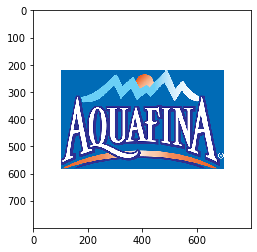

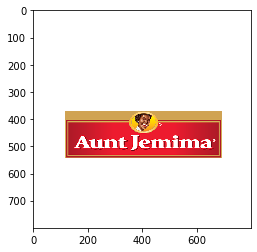

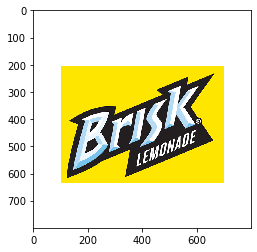

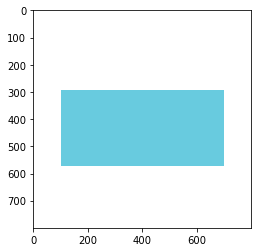

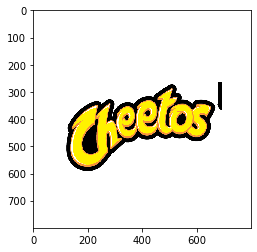

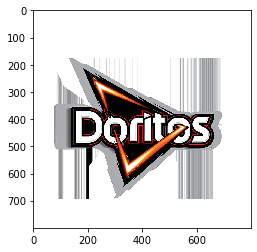

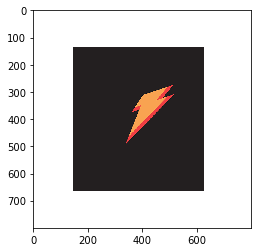

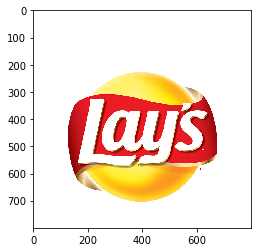

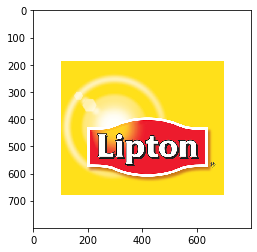

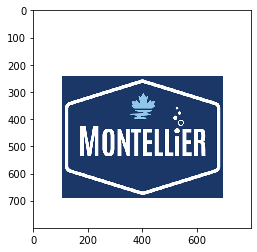

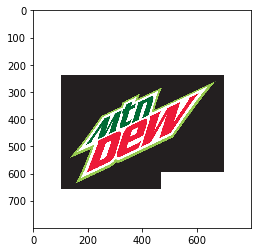

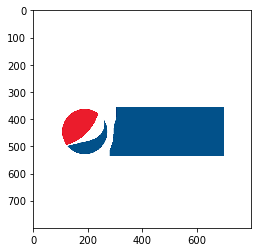

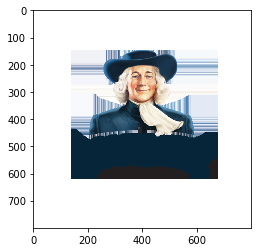

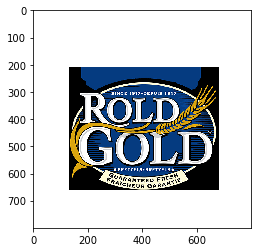

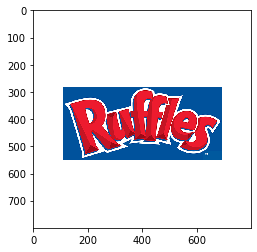

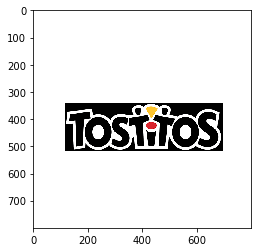

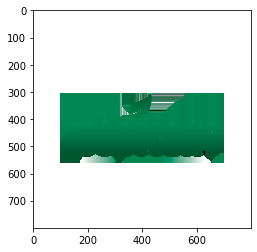

In [12]:
path = 'logos/'
raw_images = load_images(path)

clean_imgs = clean_images(raw_images,cv.COLOR_BGR2RGB)

img_list = clean_imgs.copy()

for i in range(len(img_list)):
    
#     degrees = random.randrange(0,90)
#     shrinkage = 0.7
#     img_list[i] = rotate_image(img_list[i], degrees, shrinkage)
    
#     line_color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
#     line_thickness = random.randint(1,50)
#     img_list[i] = draw_random_line(img_list[i], line_color, line_thickness)
    
#     circle_radius = random.randint(20,50)
#     circle_color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
#     circle_thickness = -1
#     img_list[i] = draw_random_circle(img_list[i], circle_radius, circle_color, circle_thickness)
    
#     num_points = random.randint(3,6)
#     poly_color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
#     img_list[i] = draw_random_filled_polygon(img_list[i],num_points,poly_color)


    
    plt.figure()
    plt.imshow(img_list[i])
    plt.show()

In [13]:
#incomplete code for master function to generate all images
def generate_images(img, instruct):
    
    print(shuffle, rotate, line, circle, polygon)
    
    rotate_image(img,degrees,shrinkage)
    draw_random_line(img, line_color, line_thickness)
    draw_random_circle(img, circle_radius, circle_color, thickness)
    draw_random_filled_polygon(img,num_points,poly_color)
    
    return new_img

n= 800


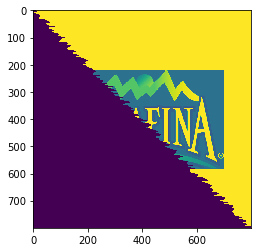

In [14]:
m,n=img_list[0].shape[:2]
print("n=",n)
sin_mask = generate_interpolated_mask(n, sin_func)
line_mask = generate_interpolated_mask(n, jagged_line, step=5)

img = cv.cvtColor(img_list[0],cv.COLOR_BGR2RGB)

plt.figure()
plt.imshow(aggregate(img, np.zeros((n, n, 3)), line_mask).sum(axis=2))
plt.show()